<a href="https://colab.research.google.com/github/asokraju/Power-Converters/blob/verified/DDPG/buck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Buck converter

In the we present the model of a buck dc-dc converter in OpenAI gym environment.

In [ ]:
import numpy as np
import gym
from gym import spaces
 
import matplotlib.pyplot as plt

##Physical Model
The dynamics of the Buck converter are:
\begin{align}
-L\dot{I} &= RI+V-uV_s\\
C\dot{V} &= I-GV
\end{align}


> ![alt text](https://i.imgur.com/AdJlqEN.png)







The parameters are:


*   L - Inductance
*   C - Capacitance
*   R - Series Resistance
*   G - Load Impedance
*   $V_s$ - Source Voltage

The state variables:
*  $I\geq 0$ - current through the inductor
*  $V\geq 0$ - voltage across the Capacitor

Input:
* $u\in (0,1)$ - duty-ratio

## Reward function

The Objective is to find an optimal policy for $u$ such that the Voltage $V$ across the capacitor is $V_d$. Consequently, we define the reward function as:

\begin{align}
r(I,V, u) & = - (V-V_d)^2 
\end{align}




In [ ]:
#@title ##Parameters

#@markdown ---

#@markdown ###System Parameters (Units in 1e-3).
Capacitance = 1 #@param {type:"slider", min:1, max:100, step:0.1}
Inductance = 1 #@param {type:"slider", min:1, max:100, step:0.1}

Resistance = 0 #@param {type:"slider", min:0, max:100, step:0.1}
load = 38.8 #@param {type:"slider", min:1, max:100, step:0.1}

#@markdown Voltage Source.
Vs = 380 #@param {type:"slider", min:100, max:500, step:10}

#@markdown Desired Voltage.
Vd = 280 #@param {type:"slider", min: 100, max:500, step:10}


C = Capacitance*1e-3
L = Inductance*1e-3
R = Resistance*1e-3
G = load*1e-3


## Gym Model

In [ ]:
class Buck_Converter_n(gym.Env):
    """
    Buck converter model following gym interface
    We are assuming that the switching frequency is very High
    Action space is continious
    """
    metadata = {'render.modes': ['console']}
 
    def __init__(self, Vs = 400, L = 0.001, C = 0.001, R = 0.001, G = 0.04, Vdes = 380, dt = 1e-5):
        super(Buck_Converter_n, self).__init__()
 
        #parameters
        self.Vs = Vs
        self.L = L
        self.C = C
        self.R = R
        self.G = G
 
        #step size; since L and C are very low, the ode becomes stiff
        #For the default parameters the step size should in the order of 1e-5
        self.T = dt
 
        #the steady-state equilibrium of the system is
        self.Vdes = Vdes
        self.Ides = self.G * self.Vdes
        self.udes = (1/self.Vs) * (1 + self.G * self.R) * self.Vdes
        self.action_des = 2*self.udes - 1
        if self.Vs <= self.Vdes:
            raise ValueError("for buck converter desired voltage should be less the source Voltage")
        
        #The control action is duty-ratio which lies between 0 and 1 (We are assuming that the switching frequency is very High)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float64)
        self.observation_space = spaces.Box(low=np.array([-np.inf, -np.inf]), high=np.array([+np.inf, +np.inf]), shape=None, dtype=np.float64)
        
        self._get_state()
    
    def _get_state(self):
        #initializing the state vector near to the desired values
        I = np.random.uniform(low = self.Ides*0.9, high = self.Ides*1.1)
        V = np.random.uniform(low = self.Vdes*0.9, high = self.Vdes*1.1)
        self.state = np.array([I, V])
 
    def _set_state(self, I, V):
        #using this function we can change the state variable
        self.state = np.array([I, V])
 
    def desired(self):
        #Provides the steady-state variables
        return np.array([self.Ides, self.Vdes, self.udes])
 
    def reset(self):
        """
        Important: re-initializing the state vector near to the desired values
        :return: (np.array) 
        """
        #self.state = np.array(np.random.normal([self.Ides , self.Vdes], 5)).astype(np.float32)
        self._get_state()
        return self.state
    
    def step(self, action):
 
        action = np.clip(action, -1.0, 1.0)
        u = (action + 1.0)/2.0
 
        i = self.state[0]
        v = self.state[1]
 
        didt = (-1.0/self.L)*(self.R*i + v - self.Vs*u)
        dvdt = (1.0/self.C)*(i - self.G*v)
 
        new_i = i + self.T * didt
        new_v = v + self.T * dvdt
 
        self.state = np.array([new_i, new_v]).astype(np.float32)
 
        # normalize the rewards
        reward = -np.abs(new_v-self.Vdes)#-np.abs(new_i-self.Ides)#((new_v-self.Vdes)/20.0)**2
        done = False
        return self.state, reward, done, {}
 
    def render(self, mode='console'):
        # Prints the error between the desired values and their corresponding states
        ei = self.state[0] - self.Ides
        ev = self.state[1] - self.Vdes
        if mode != 'console':
            raise NotImplementedError()
        # agent is represented as a cross, rest as a dot
        print("I-Ides = {:.2f}, V-Vdes = {:.2f}".format(ei, ev))
 
    def close(self):
        pass

## Testing

In [ ]:
def plot_signals(data, Ides, Vdes, dt = 1e-5):
    number_of_colors = data.shape[1]
    color = ['r', 'b']
    des = [Ides, Vdes]
    fig, ax = plt.subplots(nrows=1, ncols=data.shape[1], figsize = (8,4))
    time = np.array(range(data.shape[0]), dtype=np.float32)*dt
    for i in range(data.shape[1]):
        ax[i].plot(time, data[:, i],  c = color[i])
        ax[i].plot(time, np.full(data[:,i].shape[0], des[i]), marker = '.')
        ax[i].set_ylim(0, des[i]+50)
    ax[0].set_title('Current', fontsize=20)
    ax[0].set_xlabel('Time', fontsize=20)
    ax[1].set_title('Voltage', fontsize=20)
    ax[1].set_xlabel('Time', fontsize=20)
    plt.show()

### Constant input policy

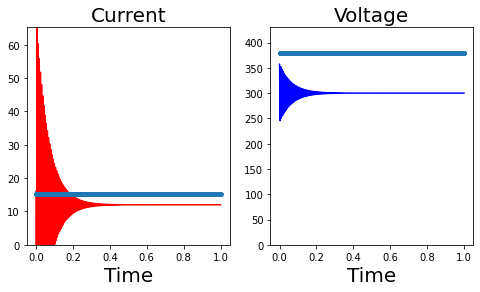

In [ ]:
env = Buck_Converter_n()

env.reset()

obs = []
for i in range(10**5):
    s, r, _, _ = env.step(0.5)
    obs.append(s)

trajectory = np.concatenate(obs).reshape((10**5 ,env.observation_space.shape[0]))
plot_signals(trajectory, env.Ides, env.Vdes, dt = 1e-5)

### Stabilizing  input policy

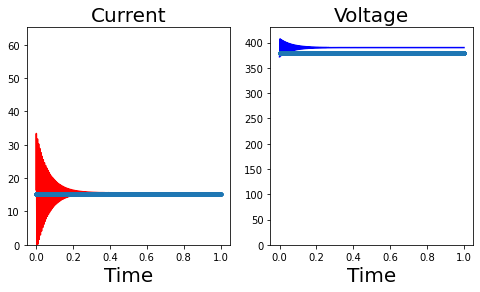

In [ ]:
env.reset()

obs = []
for i in range(10**5):
    s, r, _, _ = env.step(env.udes)
    obs.append(s)

trajectory = np.concatenate(obs).reshape((10**5 ,env.observation_space.shape[0]))
plot_signals(trajectory, env.Ides, env.Vdes, dt = 1e-5)

#Utilities

## Replay Buffer

In [ ]:
""" 
Data structure for implementing experience replay
Author: Patrick Emami
"""
from collections import deque
import random
import numpy as np

class ReplayBuffer(object):

    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences 
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)

    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size: 
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])

        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0

## OU Noise

In [ ]:
# Taken from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py, which is
# based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-5, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

## Plot

In [ ]:
##Plotting
import matplotlib.pyplot as plt

def plot_signals(data, actions, reward, Ides, Vdes, udes):
    dt=1e-5
    number_of_colors = data.shape[1]
    color = ['r', 'b','g','g']
    lim = [50,50,1.1,1.1]
    des = [Ides, Vdes, udes, 0]
    titles = ['Current', 'Voltage', 'duty-ratio', 'reward']
    time = np.array(range(data.shape[0]), dtype=np.float32)*dt
    fig, ax = plt.subplots(nrows=1, ncols=data.shape[1]+ actions.shape[1] + 1, figsize = (16,4))
    for i in range(data.shape[1]):
        ax[i].plot(time, data[:, i],  c = color[i], marker ='o')
        ax[i].plot(time, np.full(data[:,i].shape[0], des[i]), marker = '.')
        ax[i].set_ylim(des[i]-lim[i], des[i]+lim[i])
        ax[i].set_title(titles[i], fontsize=20)
        ax[i].set_xlabel('Time', fontsize=20)
    for j in range(actions.shape[1]):
        i = data.shape[1] + j
        ax[i].plot(time, actions[:, j],  c = color[i], marker ='o')
        ax[i].plot(time, np.full(actions[:,j].shape[0], des[i]), marker = '.')
        ax[i].set_ylim(-lim[i], lim[i])
        ax[i].set_title(titles[i], fontsize=20)
        ax[i].set_xlabel('Time', fontsize=20)

    ax[i+1].plot(time, reward, marker = '.')
    ax[i+1].set_ylim(min(reward), 0)
    ax[i+1].set_title(titles[i+1], fontsize=20)
    ax[i+1].set_xlabel('Time', fontsize=20)    
    plt.show()


def plot_signals2(data, actions, reward, x, Ides, Vdes):
    number_of_colors = data.shape[1]
    color = ['r', 'b']
    des = [Ides, Vdes]
    fig, ax = plt.subplots(nrows=1, ncols=data.shape[1], figsize = (8,4))
    for i in range(data.shape[1]):
        ax[i].plot(range(data.shape[0]), data[:, i],  c = color[i], marker ='o')
        ax[i].plot(range(data.shape[0]), np.full(data[:,i].shape[0], des[i]), marker = '.')
        ax[i].set_ylim(des[i]-50, des[i]+50)
    ax[0].set_title('Current', fontsize=20)
    ax[0].set_xlabel('Time', fontsize=20)
    ax[1].set_title('Voltage'.format(x), fontsize=20)
    ax[1].set_xlabel('Time', fontsize=20)
    plt.show()

def test_plot(actor):
    test_env = Buck_Converter_n(L = 0.001, C = 0.002, R = 0.001, G = .04, Vs = 400, Vdes = 200, dt = 1e-5)
    test_s = test_env.reset()
    test_obs, test_act, test_rew =[], [], []
    test_steps = 10**3
    for test_i in range(test_steps):
        test_a = actor.predict(np.reshape(test_s,(1,actor.s_dim)))
        test_a = np.clip(test_a, -1, 1)  
        test_s, test_r, _, _ = test_env.step(test_a[0])
        test_obs.append(test_s)
        test_act.append(test_a)
        test_rew.append(test_r)
    
    test_obs_reshape = np.concatenate(test_obs).reshape((test_steps ,test_env.observation_space.shape[0]))
    test_act_reshape = np.concatenate(test_act).reshape((test_steps ,1))
    
    plot_signals(test_obs_reshape, test_act_reshape, test_rew,test_env.Ides, test_env.Vdes, test_env.action_des)



#DDPG

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import gym
from gym import wrappers
import tflearn
import argparse
import pprint as pp

TensorFlow 1.x selected.








##Actor Network

In [ ]:
# ===========================
#   Actor and Critic DNNs
# ===========================

class ActorNetwork(object):
    """
    Input to the network is the state, output is the action
    under a deterministic policy.
    The output layer activation is a tanh to keep the action
    between -action_bound and action_bound
    """

    def __init__(self, sess, state_dim, action_dim, action_bound, learning_rate, tau, batch_size):
        self.sess = sess
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate
        self.tau = tau
        self.batch_size = batch_size

        # Actor Network
        self.inputs, self.out, self.scaled_out = self.create_actor_network()

        self.network_params = tf.trainable_variables()

        # Target Network
        self.target_inputs, self.target_out, self.target_scaled_out = self.create_actor_network()

        self.target_network_params = tf.trainable_variables()[
            len(self.network_params):]

        # Op for periodically updating target network with online network
        # weights
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) +
                                                  tf.multiply(self.target_network_params[i], 1. - self.tau))
                for i in range(len(self.target_network_params))]

        # This gradient will be provided by the critic network
        self.action_gradient = tf.placeholder(tf.float32, [None, self.a_dim])

        # Combine the gradients here
        self.unnormalized_actor_gradients = tf.gradients(
            self.scaled_out, self.network_params, -self.action_gradient)
        self.actor_gradients = list(map(lambda x: tf.div(x, self.batch_size), self.unnormalized_actor_gradients))

        # Optimization Op
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).\
            apply_gradients(zip(self.actor_gradients, self.network_params))

        self.num_trainable_vars = len(
            self.network_params) + len(self.target_network_params)

    def create_actor_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        net = tflearn.fully_connected(inputs, 400)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        net = tflearn.fully_connected(net, 300)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        # Final layer weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(
            net, self.a_dim, activation='tanh', weights_init=w_init)
        # Scale output to -action_bound to action_bound
        scaled_out = tf.multiply(out, self.action_bound)
        return inputs, out, scaled_out

    def train(self, inputs, a_gradient):
        self.sess.run(self.optimize, feed_dict={
            self.inputs: inputs,
            self.action_gradient: a_gradient
        })

    def predict(self, inputs):
        return self.sess.run(self.scaled_out, feed_dict={
            self.inputs: inputs
        })

    def predict_target(self, inputs):
        return self.sess.run(self.target_scaled_out, feed_dict={
            self.target_inputs: inputs
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

    def get_num_trainable_vars(self):
        return self.num_trainable_vars


## Critic Network

In [ ]:
class CriticNetwork(object):
    """
    Input to the network is the state and action, output is Q(s,a).
    The action must be obtained from the output of the Actor network.
    """

    def __init__(self, sess, state_dim, action_dim, learning_rate, tau, gamma, num_actor_vars):
        self.sess = sess
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.learning_rate = learning_rate
        self.tau = tau
        self.gamma = gamma

        # Create the critic network
        self.inputs, self.action, self.out = self.create_critic_network()

        self.network_params = tf.trainable_variables()[num_actor_vars:]

        # Target Network
        self.target_inputs, self.target_action, self.target_out = self.create_critic_network()

        self.target_network_params = tf.trainable_variables()[(len(self.network_params) + num_actor_vars):]

        # Op for periodically updating target network with online network
        # weights with regularization
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) \
            + tf.multiply(self.target_network_params[i], 1. - self.tau))
                for i in range(len(self.target_network_params))]

        # Network target (y_i)
        self.predicted_q_value = tf.placeholder(tf.float32, [None, 1])

        # Define loss and optimization Op
        self.loss = tflearn.mean_square(self.predicted_q_value, self.out)
        self.optimize = tf.train.AdamOptimizer(
            self.learning_rate).minimize(self.loss)

        # Get the gradient of the net w.r.t. the action.
        # For each action in the minibatch (i.e., for each x in xs),
        # this will sum up the gradients of each critic output in the minibatch
        # w.r.t. that action. Each output is independent of all
        # actions except for one.
        self.action_grads = tf.gradients(self.out, self.action)

    def create_critic_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        action = tflearn.input_data(shape=[None, self.a_dim])
        net = tflearn.fully_connected(inputs, 400)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)

        # Add the action tensor in the 2nd hidden layer
        # Use two temp layers to get the corresponding weights and biases
        t1 = tflearn.fully_connected(net, 300)
        t2 = tflearn.fully_connected(action, 300)

        net = tflearn.activation(
            tf.matmul(net, t1.W) + tf.matmul(action, t2.W) + t2.b, activation='relu')

        # linear layer connected to 1 output representing Q(s,a)
        # Weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(net, 1, weights_init=w_init)
        return inputs, action, out

    def train(self, inputs, action, predicted_q_value):
        return self.sess.run([self.out, self.optimize], feed_dict={
            self.inputs: inputs,
            self.action: action,
            self.predicted_q_value: predicted_q_value
        })

    def predict(self, inputs, action):
        return self.sess.run(self.out, feed_dict={
            self.inputs: inputs,
            self.action: action
        })

    def predict_target(self, inputs, action):
        return self.sess.run(self.target_out, feed_dict={
            self.target_inputs: inputs,
            self.target_action: action
        })

    def action_gradients(self, inputs, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.inputs: inputs,
            self.action: actions
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

## Tensorflow Summary Ops



In [ ]:
def build_summaries():
    episode_reward = tf.Variable(0.)
    tf.summary.scalar("Reward", episode_reward)
    episode_ave_max_q = tf.Variable(0.)
    tf.summary.scalar("Qmax Value", episode_ave_max_q)

    summary_vars = [episode_reward, episode_ave_max_q]
    summary_ops = tf.summary.merge_all()

    return summary_ops, summary_vars

## Train

In [ ]:
def train(sess, env, args, actor, critic, actor_noise, reward_result):

    # Set up summary Ops
    summary_ops, summary_vars = build_summaries()

    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(args['summary_dir'], sess.graph)

    # Initialize target network weights
    actor.update_target_network()
    critic.update_target_network()

    # Initialize replay memory
    replay_buffer = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))

    # Needed to enable BatchNorm. 
    # This hurts the performance on Pendulum but could be useful
    # in other environments.
    # tflearn.is_training(True)

    paths = list()
    
    for i in range(int(args['max_episodes'])):

        s = env.reset()

        ep_reward = 0
        ep_ave_max_q = 0

        obs, action, rewards = [], [], []
        
        for j in range(int(args['max_episode_len'])):
            
            #env.render()


            # Added exploration noise
            #a = actor.predict(np.reshape(s, (1, 3))) + (1. / (1. + i))
            a = actor.predict(np.reshape(s, (1, actor.s_dim))) + actor_noise()*((1. / (1. + i/100)))

            s2, r, terminal, info = env.step(a[0])

            replay_buffer.add(np.reshape(s, (actor.s_dim,)), np.reshape(a, (actor.a_dim,)), r,
                              terminal, np.reshape(s2, (actor.s_dim,)))

            # Keep adding experience to the memory until
            # there are at least minibatch size samples
            if replay_buffer.size() > int(args['minibatch_size']):
                s_batch, a_batch, r_batch, t_batch, s2_batch = \
                    replay_buffer.sample_batch(int(args['minibatch_size']))

                # Calculate targets
                target_q = critic.predict_target(
                    s2_batch, actor.predict_target(s2_batch))

                y_i = []
                for k in range(int(args['minibatch_size'])):
                    if t_batch[k]:
                        y_i.append(r_batch[k])
                    else:
                        y_i.append(r_batch[k] + critic.gamma * target_q[k])

                # Update the critic given the targets
                predicted_q_value, _ = critic.train(
                    s_batch, a_batch, np.reshape(y_i, (int(args['minibatch_size']), 1)))

                ep_ave_max_q += np.amax(predicted_q_value)

                # Update the actor policy using the sampled gradient
                a_outs = actor.predict(s_batch)
                grads = critic.action_gradients(s_batch, a_outs)
                actor.train(s_batch, grads[0])

                # Update target networks
                actor.update_target_network()
                critic.update_target_network()

            s = s2
            ep_reward += r

            obs.append(s)
            rewards.append(r)
            action.append(a[0])

            if terminal | j+1 == int(args['max_episode_len']):

                summary_str = sess.run(summary_ops, feed_dict={
                    summary_vars[0]: ep_reward,
                    summary_vars[1]: ep_ave_max_q / float(j)
                })

                writer.add_summary(summary_str, i)
                writer.flush()
                reshaped_obs = np.concatenate(obs).reshape((j+1 ,env.observation_space.shape[0]))
                reshaped_act = np.concatenate(action).reshape((j+1 ,env.action_space.shape[0]))
                if i%10 == 0:
                    plot_signals(reshaped_obs, reshaped_act, rewards, env.Ides, env.Vdes, env.action_des)

                print('| Reward: {:d} | Episode: {:d} | Qmax: {:.4f}'.format(int(ep_reward), \
                        i, (ep_ave_max_q / float(j))))
                reward_result[i] = ep_reward
                path = {"Observation":np.concatenate(obs).reshape((j+1 ,env.observation_space.shape[0])),
                        "Action":np.concatenate(action),
		        "Reward":np.asarray(rewards)}
                paths.append(path)

                break

    return [summary_ops, summary_vars, paths]

#Run

##Args

In [ ]:
args = {'env':'Buck_Converter_n',
        'random_seed':1234,
        'actor_lr':0.0001,
        'critic_lr':0.001,
        'tau':0.001,
        'gamma':0.99,
        'minibatch_size':100,
        'use_gym_monitor':False,
        'render_env':False,
        'buffer_size':1000000,
        'max_episodes':1000,
        'max_episode_len':5000,
        'monitor_dir':'/content/sample_data',
        'summary_dir':'/content/sample_data'
        }



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Summary name Qmax Value is illegal; using Qmax_Value instead.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


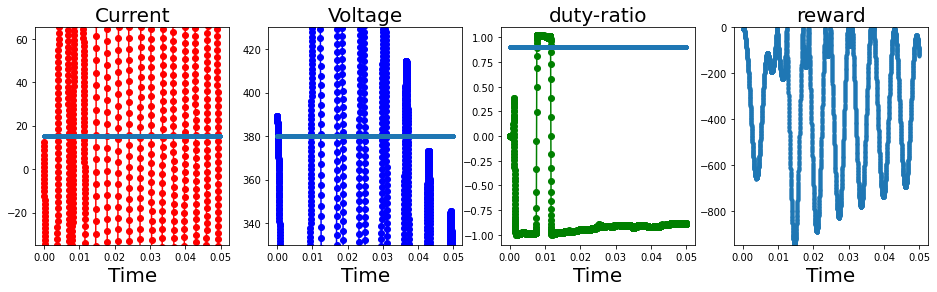

| Reward: -1784905 | Episode: 0 | Qmax: -98.8454
| Reward: -1615584 | Episode: 1 | Qmax: -182.5920
| Reward: -1263155 | Episode: 2 | Qmax: -225.3629
| Reward: -1196094 | Episode: 3 | Qmax: -281.0760
| Reward: -189668 | Episode: 4 | Qmax: -323.5166
| Reward: -45549 | Episode: 5 | Qmax: -317.7242
| Reward: -29754 | Episode: 6 | Qmax: -303.4656
| Reward: -26871 | Episode: 7 | Qmax: -271.4120
| Reward: -38747 | Episode: 8 | Qmax: -248.2289
| Reward: -43500 | Episode: 9 | Qmax: -229.0241


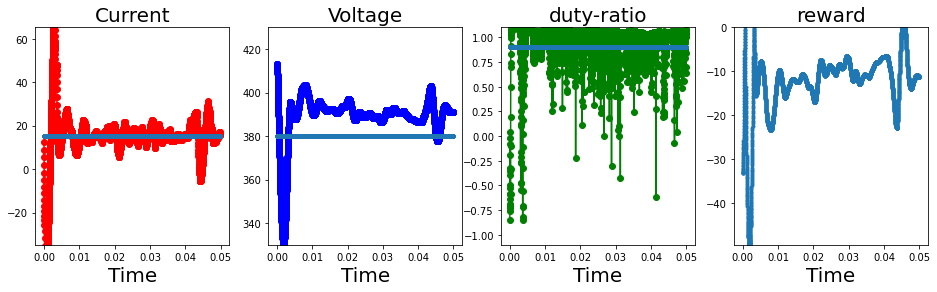

| Reward: -62546 | Episode: 10 | Qmax: -204.3533
| Reward: -67612 | Episode: 11 | Qmax: -175.1269
| Reward: -81168 | Episode: 12 | Qmax: -132.7387
| Reward: -92805 | Episode: 13 | Qmax: -100.2719
| Reward: -86403 | Episode: 14 | Qmax: -89.2398
| Reward: -92581 | Episode: 15 | Qmax: -86.1350
| Reward: -98006 | Episode: 16 | Qmax: -44.5517
| Reward: -99239 | Episode: 17 | Qmax: -9.5512
| Reward: -94258 | Episode: 18 | Qmax: -14.6710
| Reward: -98363 | Episode: 19 | Qmax: -15.0687


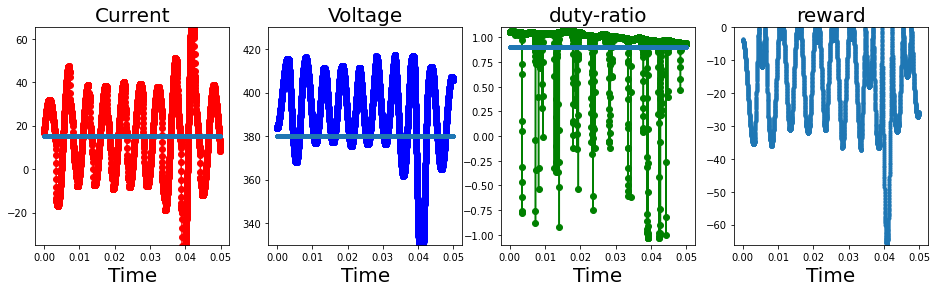

| Reward: -89683 | Episode: 20 | Qmax: -2.6933
| Reward: -52454 | Episode: 21 | Qmax: -16.1206
| Reward: -72379 | Episode: 22 | Qmax: -23.9091
| Reward: -43821 | Episode: 23 | Qmax: -3.4539
| Reward: -63189 | Episode: 24 | Qmax: 8.7931
| Reward: -91203 | Episode: 25 | Qmax: 0.9898
| Reward: -113544 | Episode: 26 | Qmax: -6.8217
| Reward: -57066 | Episode: 27 | Qmax: -27.1987
| Reward: -67351 | Episode: 28 | Qmax: -20.5349
| Reward: -52726 | Episode: 29 | Qmax: -41.6020


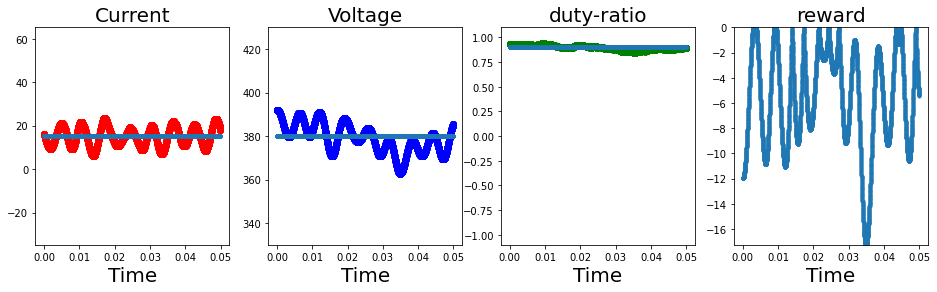

| Reward: -27828 | Episode: 30 | Qmax: -71.8783
| Reward: -33427 | Episode: 31 | Qmax: -83.8405
| Reward: -50959 | Episode: 32 | Qmax: -110.2043
| Reward: -23602 | Episode: 33 | Qmax: -130.3056
| Reward: -42356 | Episode: 34 | Qmax: -127.2179
| Reward: -41984 | Episode: 35 | Qmax: -144.2618
| Reward: -62157 | Episode: 36 | Qmax: -159.4811
| Reward: -87071 | Episode: 37 | Qmax: -162.1881
| Reward: -69173 | Episode: 38 | Qmax: -173.2452
| Reward: -42114 | Episode: 39 | Qmax: -185.8871


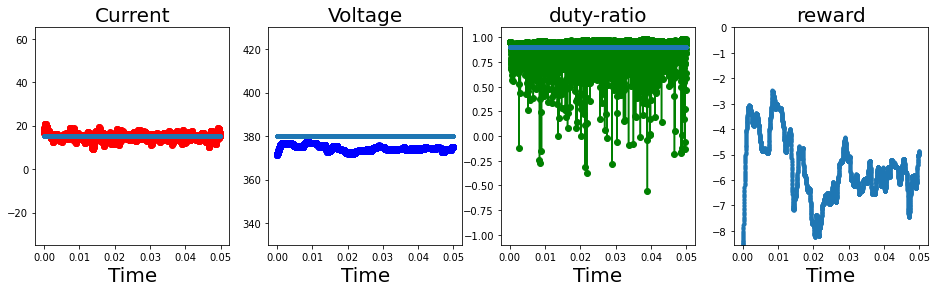

| Reward: -27624 | Episode: 40 | Qmax: -196.9384
| Reward: -33111 | Episode: 41 | Qmax: -208.3467
| Reward: -25655 | Episode: 42 | Qmax: -214.6585
| Reward: -29196 | Episode: 43 | Qmax: -214.7686
| Reward: -31466 | Episode: 44 | Qmax: -217.0645
| Reward: -31210 | Episode: 45 | Qmax: -217.3516
| Reward: -35480 | Episode: 46 | Qmax: -198.9996
| Reward: -50485 | Episode: 47 | Qmax: -187.8680
| Reward: -58109 | Episode: 48 | Qmax: -186.7054
| Reward: -83730 | Episode: 49 | Qmax: -187.5628


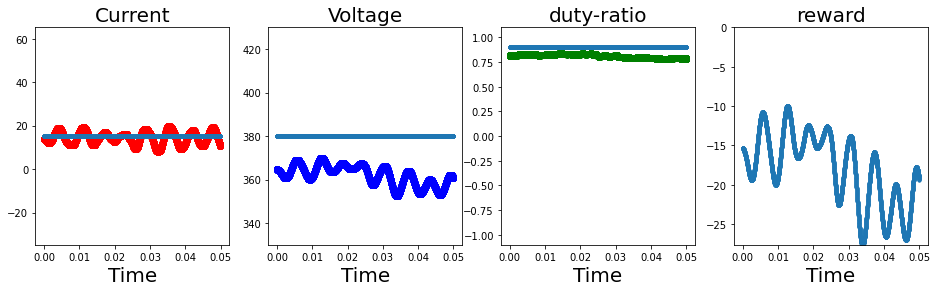

| Reward: -89603 | Episode: 50 | Qmax: -185.0041
| Reward: -134158 | Episode: 51 | Qmax: -183.5196
| Reward: -198464 | Episode: 52 | Qmax: -182.4496
| Reward: -196661 | Episode: 53 | Qmax: -181.9000
| Reward: -210186 | Episode: 54 | Qmax: -183.3962
| Reward: -238748 | Episode: 55 | Qmax: -182.3714
| Reward: -218432 | Episode: 56 | Qmax: -177.8614
| Reward: -221726 | Episode: 57 | Qmax: -173.7988
| Reward: -179315 | Episode: 58 | Qmax: -174.9568
| Reward: -166770 | Episode: 59 | Qmax: -177.8446


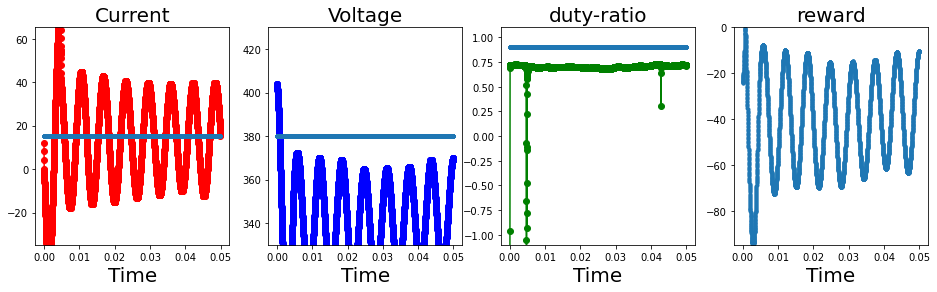

| Reward: -203075 | Episode: 60 | Qmax: -179.8686
| Reward: -228286 | Episode: 61 | Qmax: -180.4140
| Reward: -308779 | Episode: 62 | Qmax: -182.6388
| Reward: -329677 | Episode: 63 | Qmax: -187.2173
| Reward: -279761 | Episode: 64 | Qmax: -193.1787
| Reward: -312578 | Episode: 65 | Qmax: -197.1620
| Reward: -338807 | Episode: 66 | Qmax: -202.5878
| Reward: -266580 | Episode: 67 | Qmax: -200.0763
| Reward: -265237 | Episode: 68 | Qmax: -196.5918
| Reward: -266678 | Episode: 69 | Qmax: -187.9874


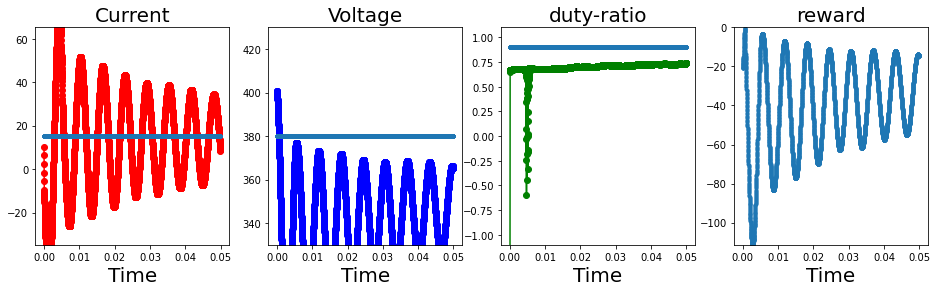

| Reward: -201278 | Episode: 70 | Qmax: -175.2194
| Reward: -168718 | Episode: 71 | Qmax: -169.4253
| Reward: -170746 | Episode: 72 | Qmax: -167.1217
| Reward: -223983 | Episode: 73 | Qmax: -160.8934
| Reward: -262973 | Episode: 74 | Qmax: -151.9561
| Reward: -296652 | Episode: 75 | Qmax: -147.2398
| Reward: -255799 | Episode: 76 | Qmax: -143.3337
| Reward: -237956 | Episode: 77 | Qmax: -139.0963
| Reward: -262615 | Episode: 78 | Qmax: -128.2505
| Reward: -187176 | Episode: 79 | Qmax: -122.7470


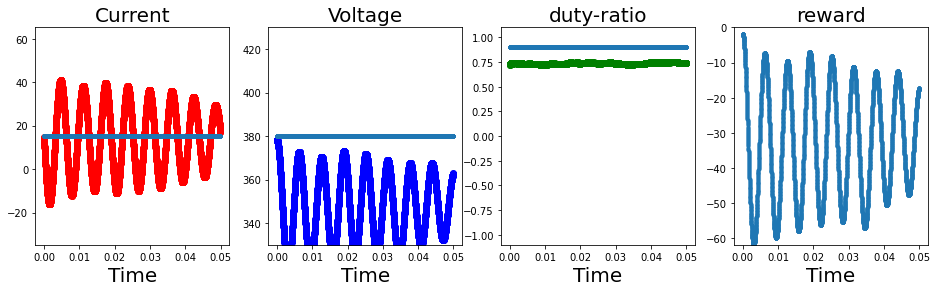

| Reward: -164120 | Episode: 80 | Qmax: -114.8002
| Reward: -172205 | Episode: 81 | Qmax: -109.5886
| Reward: -160668 | Episode: 82 | Qmax: -108.5092
| Reward: -112994 | Episode: 83 | Qmax: -105.7007
| Reward: -62516 | Episode: 84 | Qmax: -101.9300
| Reward: -99711 | Episode: 85 | Qmax: -97.1228
| Reward: -97680 | Episode: 86 | Qmax: -88.2465
| Reward: -100143 | Episode: 87 | Qmax: -80.0591
| Reward: -142036 | Episode: 88 | Qmax: -75.1962
| Reward: -168378 | Episode: 89 | Qmax: -70.4361


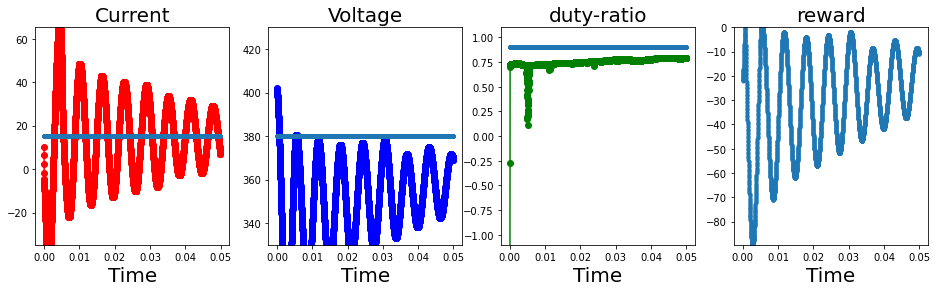

| Reward: -149663 | Episode: 90 | Qmax: -67.8153
| Reward: -84790 | Episode: 91 | Qmax: -66.7696
| Reward: -110933 | Episode: 92 | Qmax: -67.6205
| Reward: -105061 | Episode: 93 | Qmax: -70.0588
| Reward: -96641 | Episode: 94 | Qmax: -60.7088
| Reward: -99410 | Episode: 95 | Qmax: -52.4931
| Reward: -50204 | Episode: 96 | Qmax: -42.6540
| Reward: -40676 | Episode: 97 | Qmax: -34.5762
| Reward: -17213 | Episode: 98 | Qmax: -26.2083
| Reward: -9690 | Episode: 99 | Qmax: -17.0035


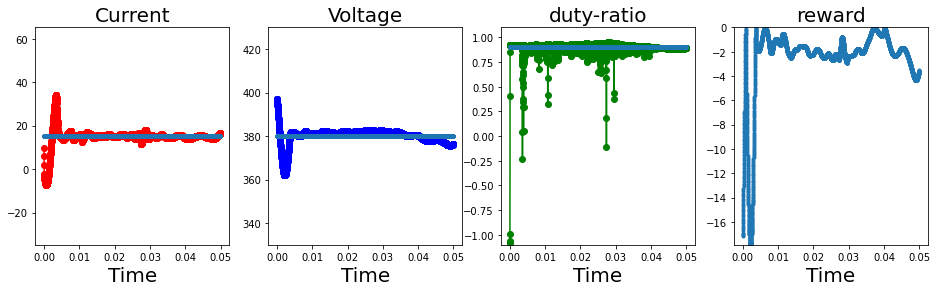

| Reward: -12235 | Episode: 100 | Qmax: -11.4345
| Reward: -9724 | Episode: 101 | Qmax: -6.9874
| Reward: -22163 | Episode: 102 | Qmax: 1.0228
| Reward: -79119 | Episode: 103 | Qmax: 7.1814
| Reward: -132758 | Episode: 104 | Qmax: 13.4901
| Reward: -119776 | Episode: 105 | Qmax: 20.5175
| Reward: -135399 | Episode: 106 | Qmax: 26.5633
| Reward: -149689 | Episode: 107 | Qmax: 30.6217
| Reward: -129473 | Episode: 108 | Qmax: 37.0406
| Reward: -143667 | Episode: 109 | Qmax: 41.0023


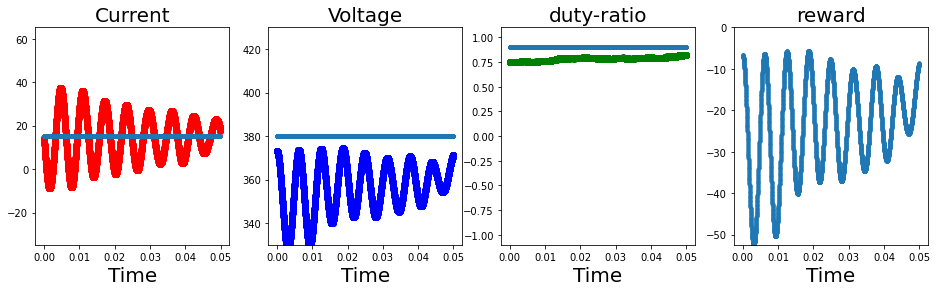

| Reward: -117815 | Episode: 110 | Qmax: 44.3320
| Reward: -75109 | Episode: 111 | Qmax: 47.4747
| Reward: -51908 | Episode: 112 | Qmax: 48.3885
| Reward: -95305 | Episode: 113 | Qmax: 50.5146
| Reward: -59985 | Episode: 114 | Qmax: 49.1000
| Reward: -16391 | Episode: 115 | Qmax: 46.6243
| Reward: -38445 | Episode: 116 | Qmax: 46.0292
| Reward: -48159 | Episode: 117 | Qmax: 45.2832
| Reward: -27411 | Episode: 118 | Qmax: 45.0601
| Reward: -54839 | Episode: 119 | Qmax: 44.9813


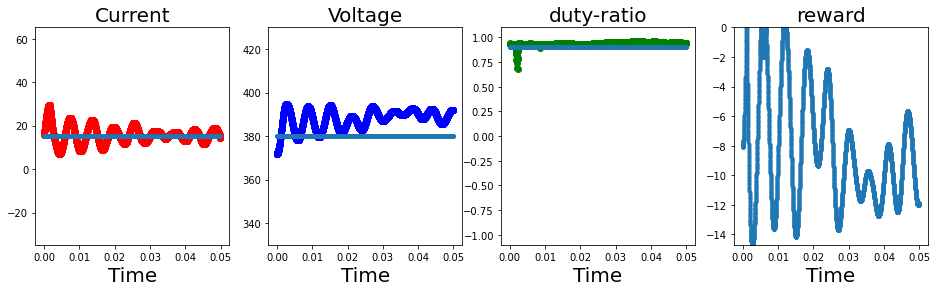

| Reward: -41638 | Episode: 120 | Qmax: 44.8478
| Reward: -32823 | Episode: 121 | Qmax: 45.0300
| Reward: -32218 | Episode: 122 | Qmax: 69.9766
| Reward: -32346 | Episode: 123 | Qmax: 63.2145
| Reward: -17777 | Episode: 124 | Qmax: 56.2786
| Reward: -31152 | Episode: 125 | Qmax: 47.1622
| Reward: -16304 | Episode: 126 | Qmax: 36.1514
| Reward: -45178 | Episode: 127 | Qmax: 25.6350
| Reward: -15500 | Episode: 128 | Qmax: 11.6445
| Reward: -33087 | Episode: 129 | Qmax: 3.0692


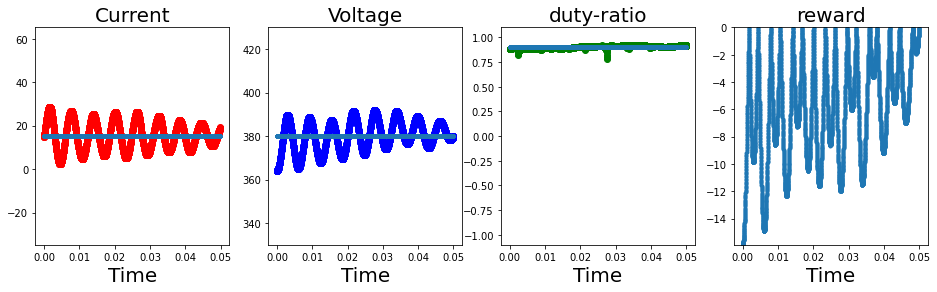

| Reward: -29991 | Episode: 130 | Qmax: -8.3901
| Reward: -28622 | Episode: 131 | Qmax: -24.4491
| Reward: -32131 | Episode: 132 | Qmax: -40.7374
| Reward: -61033 | Episode: 133 | Qmax: -63.1720
| Reward: -40282 | Episode: 134 | Qmax: -93.1748
| Reward: -41877 | Episode: 135 | Qmax: -117.8252
| Reward: -44796 | Episode: 136 | Qmax: -132.3195
| Reward: -25078 | Episode: 137 | Qmax: -135.7479
| Reward: -16031 | Episode: 138 | Qmax: -123.6248
| Reward: -11249 | Episode: 139 | Qmax: -113.4468


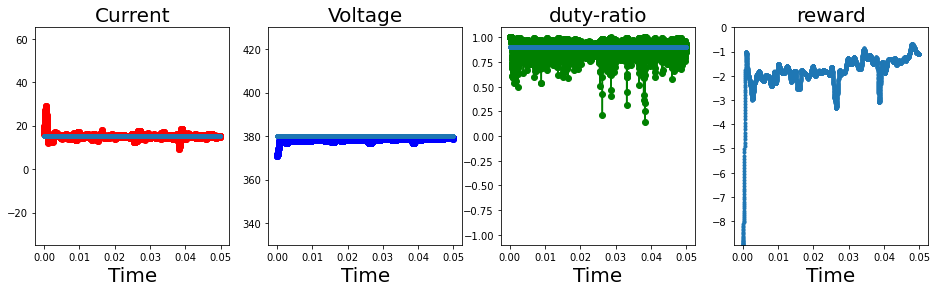

| Reward: -9055 | Episode: 140 | Qmax: -98.1105
| Reward: -6324 | Episode: 141 | Qmax: -81.2243
| Reward: -6379 | Episode: 142 | Qmax: -70.7721
| Reward: -4148 | Episode: 143 | Qmax: -58.2583
| Reward: -6716 | Episode: 144 | Qmax: -46.4906
| Reward: -5107 | Episode: 145 | Qmax: -36.0446
| Reward: -4969 | Episode: 146 | Qmax: -28.1207
| Reward: -5301 | Episode: 147 | Qmax: -21.6915
| Reward: -5173 | Episode: 148 | Qmax: -13.3243
| Reward: -6341 | Episode: 149 | Qmax: -8.4279


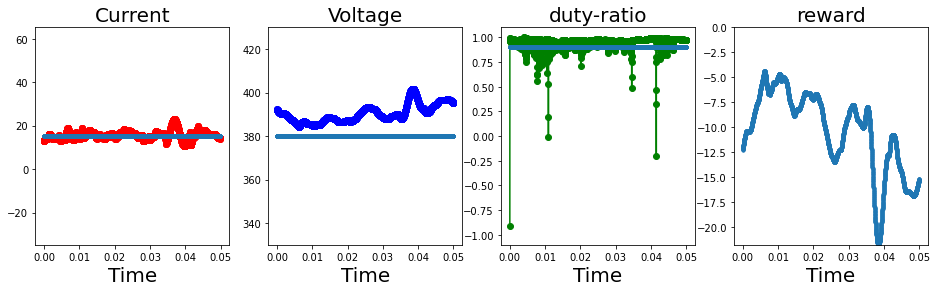

| Reward: -51505 | Episode: 150 | Qmax: -0.9675
| Reward: -55051 | Episode: 151 | Qmax: 7.8276
| Reward: -59876 | Episode: 152 | Qmax: 1.8656
| Reward: -76723 | Episode: 153 | Qmax: -4.9566
| Reward: -80520 | Episode: 154 | Qmax: -8.2911
| Reward: -95135 | Episode: 155 | Qmax: -13.4754
| Reward: -93685 | Episode: 156 | Qmax: -20.4599
| Reward: -93670 | Episode: 157 | Qmax: -32.3710
| Reward: -93809 | Episode: 158 | Qmax: -46.7557
| Reward: -89604 | Episode: 159 | Qmax: -60.8202


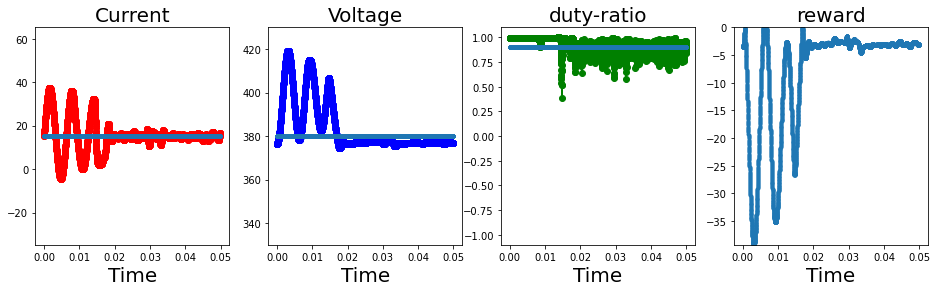

| Reward: -39085 | Episode: 160 | Qmax: -74.0653
| Reward: -11996 | Episode: 161 | Qmax: -61.3299
| Reward: -5548 | Episode: 162 | Qmax: -44.7316
| Reward: -12462 | Episode: 163 | Qmax: -39.5792
| Reward: -6047 | Episode: 164 | Qmax: -35.9608
| Reward: -4485 | Episode: 165 | Qmax: -28.2683
| Reward: -72926 | Episode: 166 | Qmax: -23.4799
| Reward: -19049 | Episode: 167 | Qmax: -17.8979
| Reward: -7381 | Episode: 168 | Qmax: -1.8640
| Reward: -4354 | Episode: 169 | Qmax: 10.5532


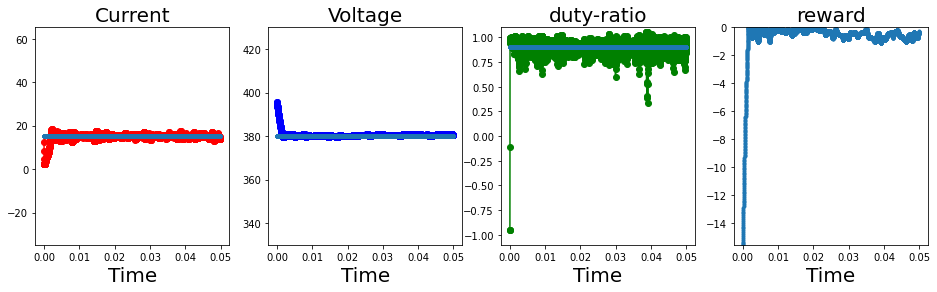

| Reward: -3203 | Episode: 170 | Qmax: 20.4411
| Reward: -5873 | Episode: 171 | Qmax: 29.0565
| Reward: -9754 | Episode: 172 | Qmax: 32.3994
| Reward: -11795 | Episode: 173 | Qmax: 33.4592
| Reward: -16148 | Episode: 174 | Qmax: 41.2635
| Reward: -31807 | Episode: 175 | Qmax: 46.9299
| Reward: -61337 | Episode: 176 | Qmax: 46.2767
| Reward: -89393 | Episode: 177 | Qmax: 42.1745
| Reward: -97440 | Episode: 178 | Qmax: 36.6000
| Reward: -99794 | Episode: 179 | Qmax: 32.2895


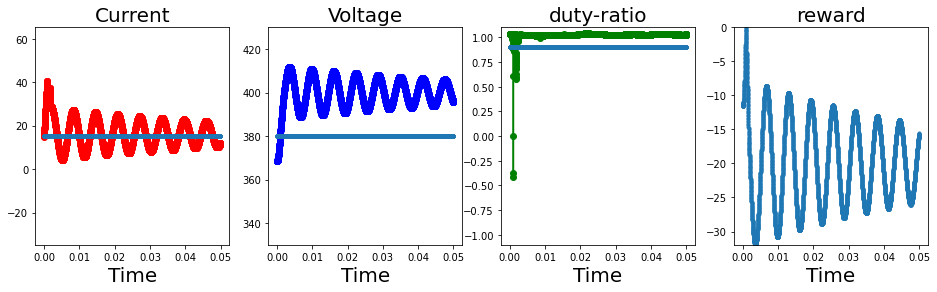

| Reward: -99389 | Episode: 180 | Qmax: 27.5675
| Reward: -99882 | Episode: 181 | Qmax: 23.6108
| Reward: -100857 | Episode: 182 | Qmax: 35.7340
| Reward: -69307 | Episode: 183 | Qmax: 43.2788
| Reward: -7772 | Episode: 184 | Qmax: 42.4522
| Reward: -17305 | Episode: 185 | Qmax: 44.7117
| Reward: -36837 | Episode: 186 | Qmax: 43.9793
| Reward: -14297 | Episode: 187 | Qmax: 48.6006
| Reward: -7308 | Episode: 188 | Qmax: 56.5958
| Reward: -7928 | Episode: 189 | Qmax: 61.7948


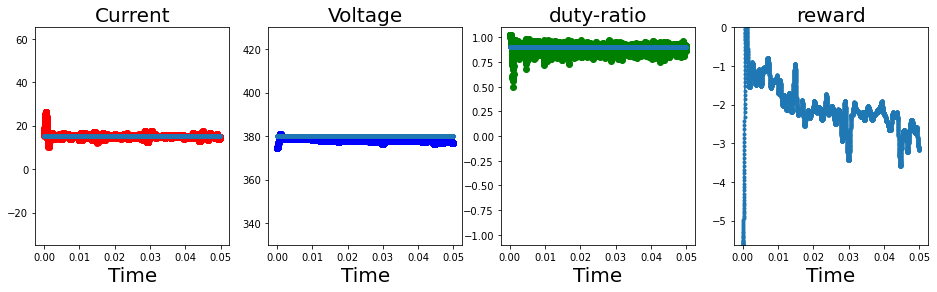

| Reward: -10513 | Episode: 190 | Qmax: 62.3282
| Reward: -15638 | Episode: 191 | Qmax: 61.4803
| Reward: -10726 | Episode: 192 | Qmax: 58.4653
| Reward: -10360 | Episode: 193 | Qmax: 58.2172
| Reward: -12998 | Episode: 194 | Qmax: 57.3588
| Reward: -6933 | Episode: 195 | Qmax: 56.4327
| Reward: -7349 | Episode: 196 | Qmax: 55.7844
| Reward: -4080 | Episode: 197 | Qmax: 55.5794
| Reward: -9746 | Episode: 198 | Qmax: 52.2843
| Reward: -9275 | Episode: 199 | Qmax: 50.5133


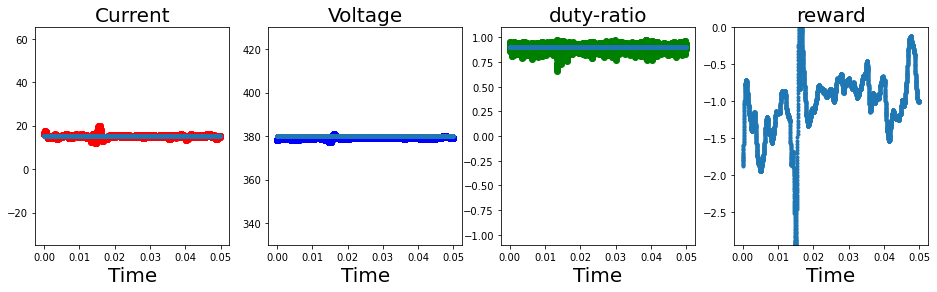

| Reward: -5160 | Episode: 200 | Qmax: 50.8086
| Reward: -4879 | Episode: 201 | Qmax: 50.2570
| Reward: -2195 | Episode: 202 | Qmax: 46.7513
| Reward: -11771 | Episode: 203 | Qmax: 44.0869
| Reward: -8366 | Episode: 204 | Qmax: 37.6422
| Reward: -7418 | Episode: 205 | Qmax: 36.1965
| Reward: -11799 | Episode: 206 | Qmax: 34.1152
| Reward: -5536 | Episode: 207 | Qmax: 32.5060
| Reward: -7463 | Episode: 208 | Qmax: 30.5998
| Reward: -5718 | Episode: 209 | Qmax: 29.9863


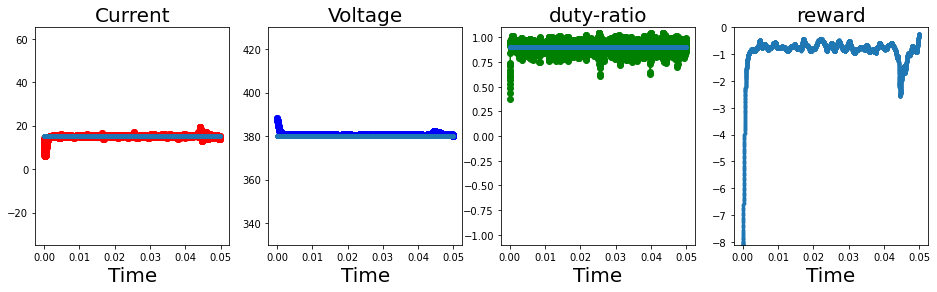

| Reward: -4359 | Episode: 210 | Qmax: 28.8742
| Reward: -6494 | Episode: 211 | Qmax: 27.8317
| Reward: -4557 | Episode: 212 | Qmax: 28.2427
| Reward: -6027 | Episode: 213 | Qmax: 28.3612
| Reward: -3441 | Episode: 214 | Qmax: 28.5950
| Reward: -3553 | Episode: 215 | Qmax: 28.2242
| Reward: -6453 | Episode: 216 | Qmax: 28.6632
| Reward: -3491 | Episode: 217 | Qmax: 29.3367
| Reward: -1333 | Episode: 218 | Qmax: 31.3630
| Reward: -4082 | Episode: 219 | Qmax: 34.7039


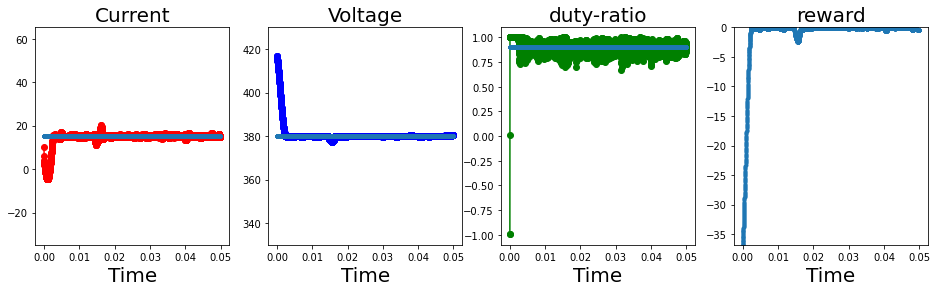

| Reward: -4788 | Episode: 220 | Qmax: 39.0831
| Reward: -3602 | Episode: 221 | Qmax: 42.6295
| Reward: -6913 | Episode: 222 | Qmax: 44.8337
| Reward: -2836 | Episode: 223 | Qmax: 45.7894
| Reward: -2855 | Episode: 224 | Qmax: 46.5672
| Reward: -4801 | Episode: 225 | Qmax: 46.8460
| Reward: -5637 | Episode: 226 | Qmax: 46.7427
| Reward: -3772 | Episode: 227 | Qmax: 47.2684
| Reward: -4048 | Episode: 228 | Qmax: 48.8834
| Reward: -2208 | Episode: 229 | Qmax: 51.2101


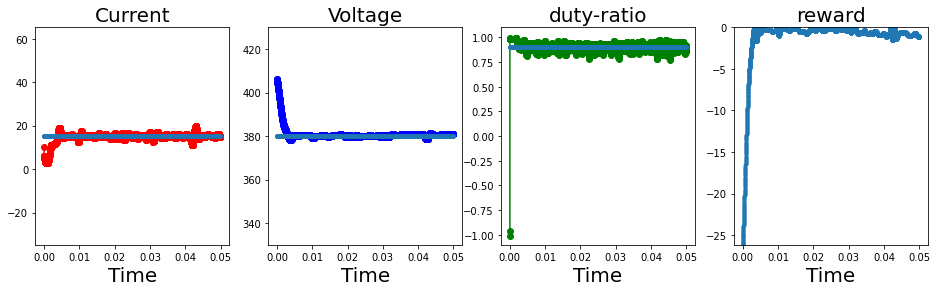

| Reward: -5480 | Episode: 230 | Qmax: 51.5751
| Reward: -4811 | Episode: 231 | Qmax: 51.1600
| Reward: -5237 | Episode: 232 | Qmax: 50.9249
| Reward: -8519 | Episode: 233 | Qmax: 49.2602
| Reward: -6658 | Episode: 234 | Qmax: 49.9321
| Reward: -3863 | Episode: 235 | Qmax: 48.5459
| Reward: -6914 | Episode: 236 | Qmax: 49.5024
| Reward: -6157 | Episode: 237 | Qmax: 51.6265
| Reward: -3364 | Episode: 238 | Qmax: 51.7464
| Reward: -3689 | Episode: 239 | Qmax: 48.2209


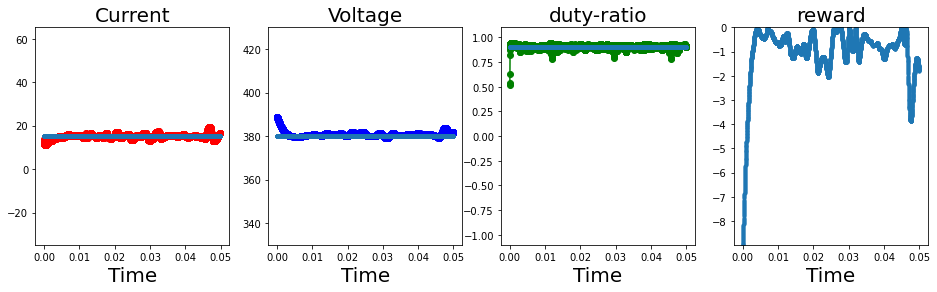

| Reward: -5015 | Episode: 240 | Qmax: 42.3016
| Reward: -10454 | Episode: 241 | Qmax: 32.1355
| Reward: -7057 | Episode: 242 | Qmax: 20.5435
| Reward: -28306 | Episode: 243 | Qmax: 6.2072
| Reward: -37129 | Episode: 244 | Qmax: -8.3476
| Reward: -41377 | Episode: 245 | Qmax: -23.5300
| Reward: -43416 | Episode: 246 | Qmax: -36.4767
| Reward: -46858 | Episode: 247 | Qmax: -46.7786
| Reward: -25701 | Episode: 248 | Qmax: -56.7395
| Reward: -20046 | Episode: 249 | Qmax: -66.5700


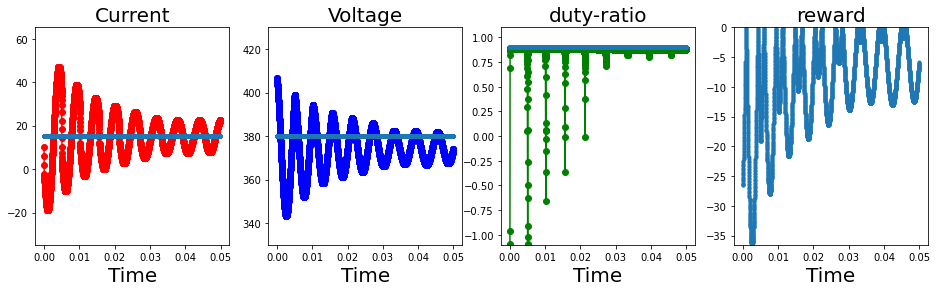

| Reward: -49324 | Episode: 250 | Qmax: -76.2650
| Reward: -61191 | Episode: 251 | Qmax: -85.8485
| Reward: -49079 | Episode: 252 | Qmax: -94.7383
| Reward: -53218 | Episode: 253 | Qmax: -103.8253
| Reward: -48166 | Episode: 254 | Qmax: -113.3893
| Reward: -58514 | Episode: 255 | Qmax: -122.5334
| Reward: -82460 | Episode: 256 | Qmax: -132.1539
| Reward: -90833 | Episode: 257 | Qmax: -142.6799
| Reward: -73076 | Episode: 258 | Qmax: -153.6425
| Reward: -66280 | Episode: 259 | Qmax: -166.3221


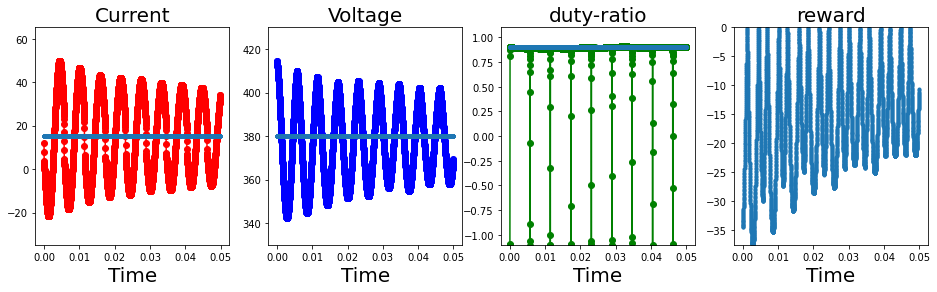

| Reward: -84108 | Episode: 260 | Qmax: -178.9199
| Reward: -26063 | Episode: 261 | Qmax: -192.6133
| Reward: -71880 | Episode: 262 | Qmax: -205.9933
| Reward: -37685 | Episode: 263 | Qmax: -220.4711
| Reward: -26630 | Episode: 264 | Qmax: -234.8051
| Reward: -12076 | Episode: 265 | Qmax: -249.2251
| Reward: -63539 | Episode: 266 | Qmax: -264.1552
| Reward: -72299 | Episode: 267 | Qmax: -259.9991
| Reward: -19127 | Episode: 268 | Qmax: -248.8669
| Reward: -18872 | Episode: 269 | Qmax: -232.4164


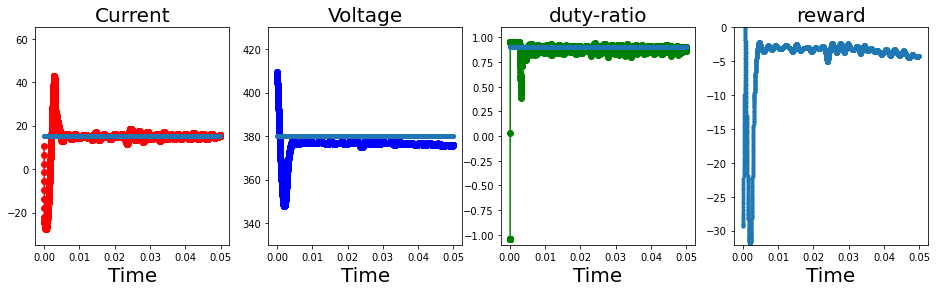

| Reward: -22491 | Episode: 270 | Qmax: -204.4173
| Reward: -29233 | Episode: 271 | Qmax: -156.8273
| Reward: -30639 | Episode: 272 | Qmax: -81.4501
| Reward: -18945 | Episode: 273 | Qmax: -22.2921
| Reward: -25428 | Episode: 274 | Qmax: 7.2989
| Reward: -29217 | Episode: 275 | Qmax: 0.7173
| Reward: -34085 | Episode: 276 | Qmax: -23.4177
| Reward: -40797 | Episode: 277 | Qmax: -58.6568
| Reward: -43257 | Episode: 278 | Qmax: -89.2677
| Reward: -52901 | Episode: 279 | Qmax: -112.3297


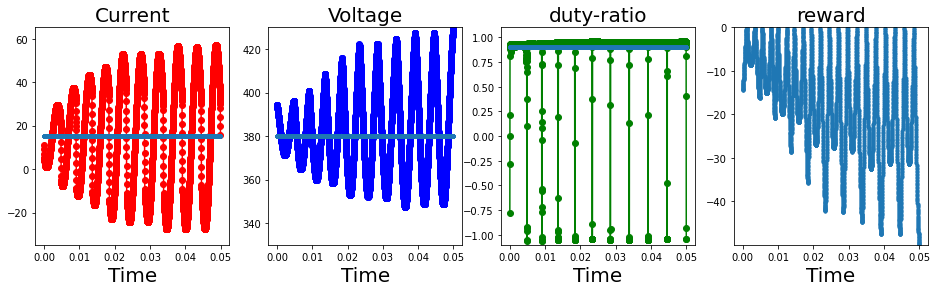

| Reward: -91321 | Episode: 280 | Qmax: -122.0017
| Reward: -74768 | Episode: 281 | Qmax: -125.1922
| Reward: -78841 | Episode: 282 | Qmax: -125.1949
| Reward: -70833 | Episode: 283 | Qmax: -123.1987
| Reward: -129974 | Episode: 284 | Qmax: -118.1072
| Reward: -42919 | Episode: 285 | Qmax: -110.8252
| Reward: -17084 | Episode: 286 | Qmax: -99.8655
| Reward: -32219 | Episode: 287 | Qmax: -90.7432
| Reward: -58089 | Episode: 288 | Qmax: -84.5873
| Reward: -10313 | Episode: 289 | Qmax: -80.6424


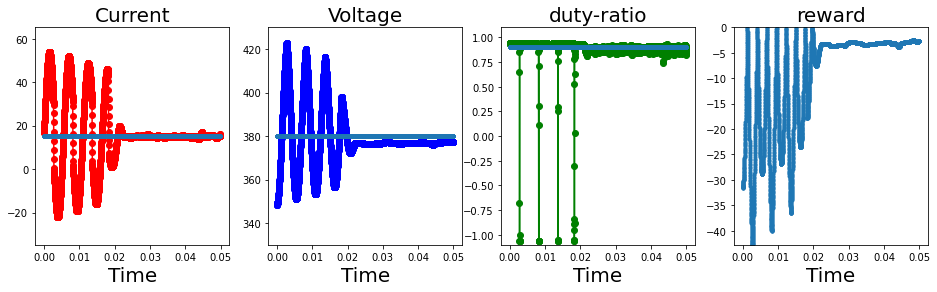

| Reward: -47163 | Episode: 290 | Qmax: -76.2667
| Reward: -9298 | Episode: 291 | Qmax: -67.6675
| Reward: -10284 | Episode: 292 | Qmax: -60.6153
| Reward: -6584 | Episode: 293 | Qmax: -55.3875
| Reward: -5197 | Episode: 294 | Qmax: -51.6664
| Reward: -7524 | Episode: 295 | Qmax: -50.6313
| Reward: -6220 | Episode: 296 | Qmax: -51.1712
| Reward: -13358 | Episode: 297 | Qmax: -52.3138
| Reward: -12840 | Episode: 298 | Qmax: -52.7542
| Reward: -6969 | Episode: 299 | Qmax: -52.1719


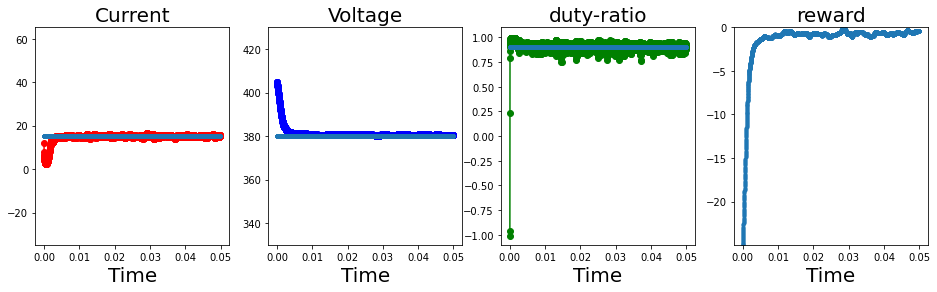

| Reward: -6666 | Episode: 300 | Qmax: -51.1288
| Reward: -8005 | Episode: 301 | Qmax: -50.7579
| Reward: -5943 | Episode: 302 | Qmax: -51.9710
| Reward: -3267 | Episode: 303 | Qmax: -53.7678
| Reward: -2836 | Episode: 304 | Qmax: -55.4436
| Reward: -6440 | Episode: 305 | Qmax: -55.7148
| Reward: -2357 | Episode: 306 | Qmax: -55.8160
| Reward: -2144 | Episode: 307 | Qmax: -54.6858
| Reward: -6287 | Episode: 308 | Qmax: -52.7897
| Reward: -4537 | Episode: 309 | Qmax: -52.3946


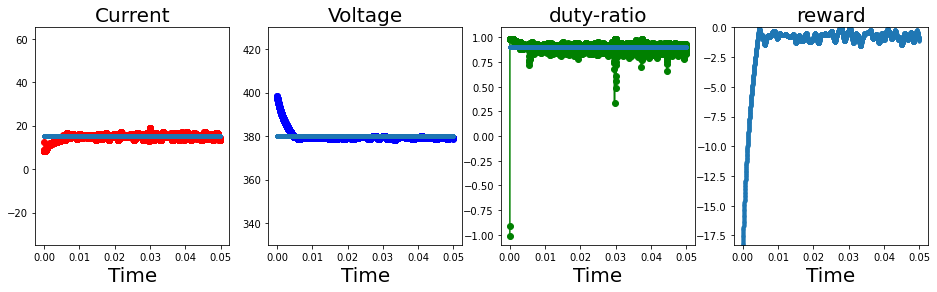

| Reward: -6671 | Episode: 310 | Qmax: -49.3236
| Reward: -3750 | Episode: 311 | Qmax: -46.6259
| Reward: -1665 | Episode: 312 | Qmax: -46.6060
| Reward: -4633 | Episode: 313 | Qmax: -48.5145
| Reward: -3900 | Episode: 314 | Qmax: -50.1362
| Reward: -1809 | Episode: 315 | Qmax: -49.3241
| Reward: -5939 | Episode: 316 | Qmax: -46.8902
| Reward: -6372 | Episode: 317 | Qmax: -44.0061
| Reward: -8103 | Episode: 318 | Qmax: -41.0208
| Reward: -8812 | Episode: 319 | Qmax: -38.7914


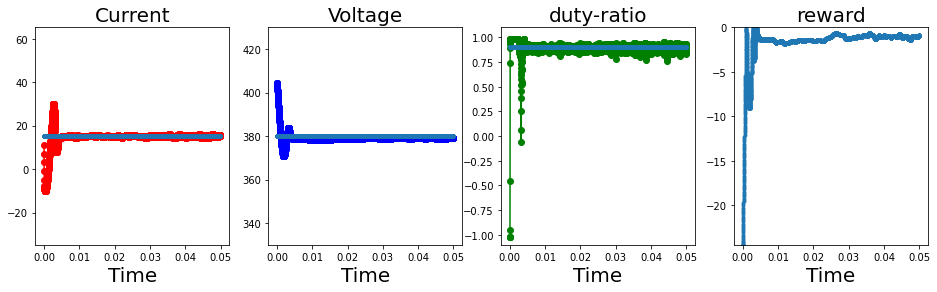

| Reward: -8123 | Episode: 320 | Qmax: -38.9869
| Reward: -8549 | Episode: 321 | Qmax: -41.5764
| Reward: -21897 | Episode: 322 | Qmax: -40.8283
| Reward: -30617 | Episode: 323 | Qmax: -41.0718
| Reward: -33051 | Episode: 324 | Qmax: -43.3840
| Reward: -36308 | Episode: 325 | Qmax: -45.5030
| Reward: -35062 | Episode: 326 | Qmax: -45.4657
| Reward: -15059 | Episode: 327 | Qmax: -32.3119
| Reward: -11990 | Episode: 328 | Qmax: -17.0204
| Reward: -4098 | Episode: 329 | Qmax: -11.9640


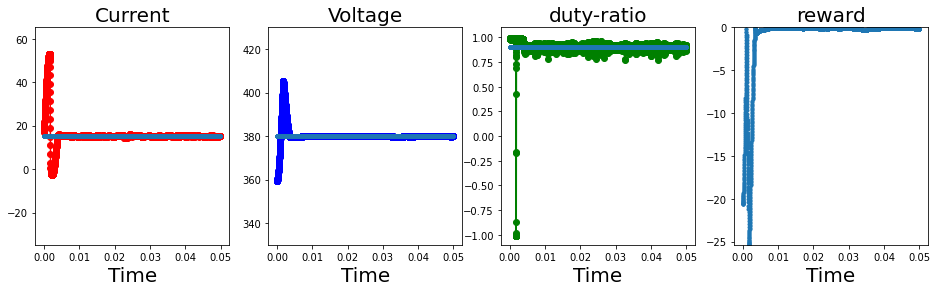

| Reward: -4800 | Episode: 330 | Qmax: -13.1062
| Reward: -7006 | Episode: 331 | Qmax: -12.8321
| Reward: -4545 | Episode: 332 | Qmax: -12.9189
| Reward: -5305 | Episode: 333 | Qmax: -13.3821
| Reward: -9882 | Episode: 334 | Qmax: -8.0223
| Reward: -10832 | Episode: 335 | Qmax: -3.3540
| Reward: -16320 | Episode: 336 | Qmax: -0.6555
| Reward: -12393 | Episode: 337 | Qmax: -0.4218
| Reward: -15141 | Episode: 338 | Qmax: -1.1596
| Reward: -13251 | Episode: 339 | Qmax: -3.0300


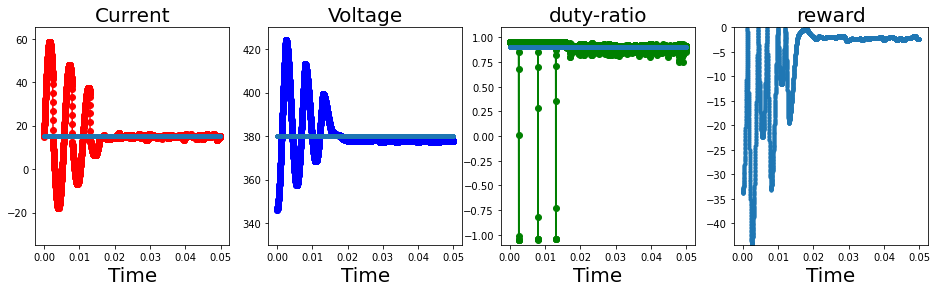

| Reward: -32446 | Episode: 340 | Qmax: -5.5378
| Reward: -10465 | Episode: 341 | Qmax: -7.9362
| Reward: -24853 | Episode: 342 | Qmax: -10.3639
| Reward: -17759 | Episode: 343 | Qmax: -12.3085
| Reward: -24237 | Episode: 344 | Qmax: -12.8060
| Reward: -23558 | Episode: 345 | Qmax: -12.8026
| Reward: -23885 | Episode: 346 | Qmax: -12.7457
| Reward: -27126 | Episode: 347 | Qmax: -10.4563
| Reward: -38849 | Episode: 348 | Qmax: -6.3266
| Reward: -54090 | Episode: 349 | Qmax: -7.5226


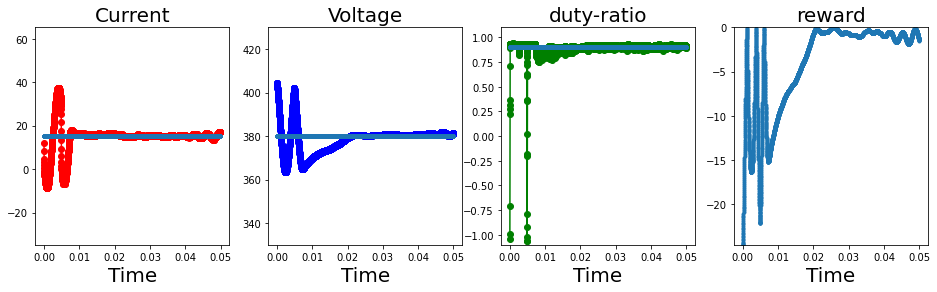

| Reward: -19355 | Episode: 350 | Qmax: -0.1315
| Reward: -39035 | Episode: 351 | Qmax: -4.1566
| Reward: -41693 | Episode: 352 | Qmax: -20.8684
| Reward: -31030 | Episode: 353 | Qmax: -6.1858
| Reward: -160293 | Episode: 354 | Qmax: -9.9497
| Reward: -166739 | Episode: 355 | Qmax: -15.1465
| Reward: -243012 | Episode: 356 | Qmax: -16.1804
| Reward: -236739 | Episode: 357 | Qmax: -13.7359
| Reward: -19121 | Episode: 358 | Qmax: -10.6468
| Reward: -20807 | Episode: 359 | Qmax: -7.8148


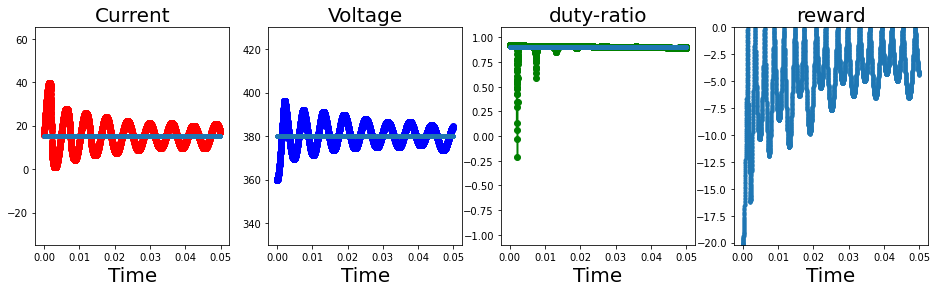

| Reward: -24923 | Episode: 360 | Qmax: -6.7481
| Reward: -19974 | Episode: 361 | Qmax: -10.0244
| Reward: -396581 | Episode: 362 | Qmax: -1.2296


In [ ]:
with tf.Session() as sess:
 
    env = Buck_Converter_n()#gym.make(args['env'])
    np.random.seed(int(args['random_seed']))
    tf.set_random_seed(int(args['random_seed']))
    env.seed(int(args['random_seed']))
 
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    action_bound = env.action_space.high
    # Ensure action bound is symmetric
    assert (env.action_space.high == -env.action_space.low)
 
    actor = ActorNetwork(sess, state_dim, action_dim, action_bound,
                            float(args['actor_lr']), float(args['tau']),
                            int(args['minibatch_size']))
 
    critic = CriticNetwork(sess, state_dim, action_dim,
                            float(args['critic_lr']), float(args['tau']),
                            float(args['gamma']),
                            actor.get_num_trainable_vars())
    
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))
 
    if args['use_gym_monitor']:
        if not args['render_env']:
            env = wrappers.Monitor(
                env, args['monitor_dir'], video_callable=False, force=True)
        else:
            env = wrappers.Monitor(env, args['monitor_dir'], force=True)
    
    reward_result = np.zeros(2500) 
    summary_ops, summary_vars, paths = train(sess, env, args, actor, critic, actor_noise, reward_result)
 
    if args['use_gym_monitor']:
        env.monitor.close()